# CityLines

## Download the dataset

Download the CSV files from https://kaggle.com/citylines/city-lines into a subfolder called `citylines` and unzip them.

In [1]:
ls citylines

cities.csv  station_lines.csv  systems.csv      tracks.csv
lines.csv   stations.csv       track_lines.csv


# Reading CSV files 

## Using the standard libary module csv

In [2]:
import csv

In [3]:
with open('citylines/cities.csv') as f:
    reader = csv.DictReader(f)
    cities = [line for line in reader]

In [4]:
print(len(cities))

334


## Loading CSVs using pandas

In [5]:
import pandas as pd
systems = pd.read_csv('citylines/systems.csv', index_col='id')
cities = pd.read_csv('citylines/cities.csv', index_col="id")
track_lines = pd.read_csv('citylines/track_lines.csv', index_col='id')
stations = pd.read_csv('citylines/stations.csv', index_col='id')
station_lines = pd.read_csv('citylines/station_lines.csv', index_col='id')
lines = pd.read_csv('citylines/lines.csv', index_col='id')
tracks = pd.read_csv('citylines/tracks.csv', index_col='id')

In [6]:
cities

,name,coords,start_year,url_name,country,country_state
id,,,,,,
5,Aberdeen,POINT(-2.15 57.15),2017.0,aberdeen,Scotland,NaN
6,Adelaide,POINT(138.6 -34.91666667),2017.0,adelaide,Australia,NaN
7,Algiers,POINT(3 36.83333333),2017.0,algiers,Algeria,NaN
9,Ankara,POINT(32.91666667 39.91666667),2017.0,ankara,Turkey,NaN
16,Belém,POINT(-48.48333333 -1.466666667),2017.0,belem,Brazil,NaN
...,...,...,...,...,...,...
265,Nantes,POINT(-1.553889 47.217222),1877.0,nantes,France,NaN
110,Stockholm,POINT(18.05 59.28333333),1919.0,stockholm,Sweden,NaN
266,Rennes,POINT(-1.680833 48.114167),1897.0,rennes,France,NaN


`pandas` dataframes provide many methods for working with tabular data. 

In [7]:
# addressing a specific cells of a pandas data frame
cities['name'][16]

'Belém'

## Parsing coordinate strings

Somd data in this data set are not normalized, i.e. entire sets of values are written into individual cells in the form of string. These need to be parsed out. For example, the `geometry` field in the the `tracks` table contains the coordinates of the line waypoints as a string.

In [9]:
g = tracks['geometry'][16]
g

'LINESTRING(-58.4565034467506 -34.5622493173683,-58.4577927653747 -34.5607441036916,-58.4591937797194 -34.5591074989372,-58.4607837178131 -34.5573661677451,-58.4616310994955 -34.5564367568353,-58.4624199130135 -34.5556111854062)'

In [11]:
# find the positions of the opening and closing parenthesis
start, end = g.find('('), g.find(')')
start, end

(10, 226)

In [12]:
# extract the part inside the parenthesis
g[start+1:end]

'-58.4565034467506 -34.5622493173683,-58.4577927653747 -34.5607441036916,-58.4591937797194 -34.5591074989372,-58.4607837178131 -34.5573661677451,-58.4616310994955 -34.5564367568353,-58.4624199130135 -34.5556111854062'

In [13]:
# split the coordinate pairs into a list
g[start+1:end].split(',')

['-58.4565034467506 -34.5622493173683',
 '-58.4577927653747 -34.5607441036916',
 '-58.4591937797194 -34.5591074989372',
 '-58.4607837178131 -34.5573661677451',
 '-58.4616310994955 -34.5564367568353',
 '-58.4624199130135 -34.5556111854062']

In [14]:
# finally, convert into a 2D numpy array
import numpy as np
points = [[float(f) for f in pair.split(' ')]  for pair in g[start+1:end].split(',')]
np.array(points)

array([[-58.45650345, -34.56224932],
       [-58.45779277, -34.5607441 ],
       [-58.45919378, -34.5591075 ],
       [-58.46078372, -34.55736617],
       [-58.4616311 , -34.55643676],
       [-58.46241991, -34.55561119]])

### organize parsers as functions

Now organize compose these steps into a function: 

In [15]:
def parse_linestring(geometry):
    """
    :param geometry: a string in the format "LINESTRING(x1 y1, x2 y2, ..., xn yn)"
    return numpy array of shape (n, 2) with coordinates
    """
    start = geometry.find('(')
    end = geometry.find(')')
    substring = geometry[start+1:end]
    return np.array(
        [[float(f) for f in pair.split(' ')] for pair in substring.split(',')])
    

In [16]:
# test it
parse_linestring(tracks['geometry'][2563])

array([[16.4151057, 48.1907238],
       [16.4156455, 48.190389 ],
       [16.4170845, 48.1895171]])

In [17]:
# similarly, define a function that takes a single point for the city coords for example.
def parse_point(coords):
    """
    :param coords: a string in the form "POINT(x, y)"
    :return: [x, y] as floats
    """
    start, end = coords.find('('), coords.find(')')
    return [float(p) for p in coords[start+1:end].split(' ')]

In [18]:
cities['name'][16], parse_point(cities['coords'][16])

('Belém', [-48.48333333, -1.466666667])

### Plot all cities
Use our point parsing function to plot all cities on the map

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

In [20]:
city_points = np.array([parse_point(p) for p in cities['coords']])

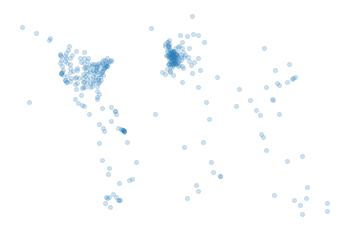

In [21]:
plt.scatter(city_points[:,0], city_points[:,1], s=16, alpha=0.2);
plt.axis(False);

### plot the transit system of a given city

In [22]:
cities

,name,coords,start_year,url_name,country,country_state
id,,,,,,
5,Aberdeen,POINT(-2.15 57.15),2017.0,aberdeen,Scotland,NaN
6,Adelaide,POINT(138.6 -34.91666667),2017.0,adelaide,Australia,NaN
7,Algiers,POINT(3 36.83333333),2017.0,algiers,Algeria,NaN
9,Ankara,POINT(32.91666667 39.91666667),2017.0,ankara,Turkey,NaN
16,Belém,POINT(-48.48333333 -1.466666667),2017.0,belem,Brazil,NaN
...,...,...,...,...,...,...
265,Nantes,POINT(-1.553889 47.217222),1877.0,nantes,France,NaN
110,Stockholm,POINT(18.05 59.28333333),1919.0,stockholm,Sweden,NaN
266,Rennes,POINT(-1.680833 48.114167),1897.0,rennes,France,NaN


First, learn about the Python `zip` function to be able to iterate over two sequencies at once.

In [27]:
seq1 = 1, 2, 3
seq2 = 'abc'

In [28]:
for i in seq1:
    print(i)
for j in seq2:
    print(j)

1
2
3
a
b
c


In [31]:
# iterate over both sequences at once
for i in range(len(seq1)):
    print(seq1[i], seq2[i])

1 a
2 b
3 c


In [32]:
# same thing with zip
for i, j in zip(seq1, seq2):
    print(i, j)

1 a
2 b
3 c


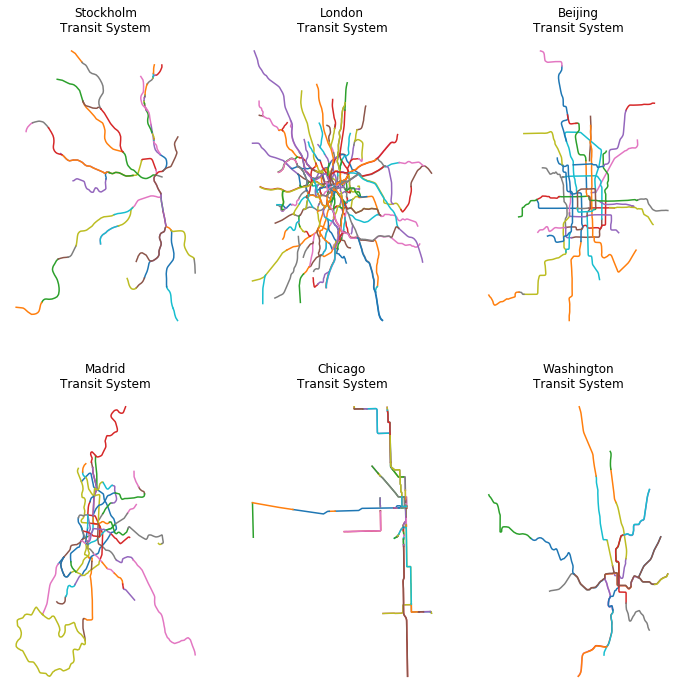

In [33]:
codes = 110, 69, 15, 71, 147, 252

fig, axx = plt.subplots(2, 3, figsize=(12, 12))

for code, ax in zip(codes, axx.flatten()):
    name = cities['name'][code]
    for line in tracks[tracks['city_id'] == code]['geometry']:
        xy = parse_linestring(line)
        ax.plot(xy[:,0], xy[:, 1])
    ax.set_title(f'{name}\nTransit System')
    ax.axis(False);
    
fig.savefig('map.png', dpi=300)

Now recall our function `route_length` from Homework Set 3 to compute the length of a route from the coordinates of its waypoints. 

In [36]:
# compute the length (km) of a line

import math
def route_length(line): 
    """
    distance of a line defined by a sequence of n waypoints 
    :param line: is a numpy array of shape (n, 2) 
    :return: length of the line in km
    """
    earth_radius = 6371
    assert len(cities) >=2, 'at least two cities are requied'
    
    point1 = line[0]
    total = 0.0
    for point2 in line[1:]:
        x1, y1 = math.radians(point1[0]), math.radians(point1[1])
        x2, y2 = math.radians(point2[0]), math.radians(point2[1])
        total += math.asin(math.sqrt(
            math.sin((x2 - x1) / 2)**2 + 
            math.cos(y1) * math.cos(y2) * math.sin((y2 - y1) / 2)**2))
        point1 = point2
    return total * 2 * earth_radius

In [37]:
codes = 110, 69, 15, 71, 147, 252, 114

for code in codes:
    name = cities['name'][code]
    length = 0
    for line in tracks[tracks['city_id'] == code]['geometry']:
        xy = parse_linestring(line)
        length += route_length(xy)
    print(f"The length of the {name} transit system is {length:.1f} km")

The length of the Stockholm transit system is 189.9 km
The length of the London transit system is 2394.6 km
The length of the Beijing transit system is 727.2 km
The length of the Madrid transit system is 340.8 km
The length of the Chicago transit system is 200.2 km
The length of the Washington transit system is 332.6 km
The length of the Tokyo transit system is 5204.0 km


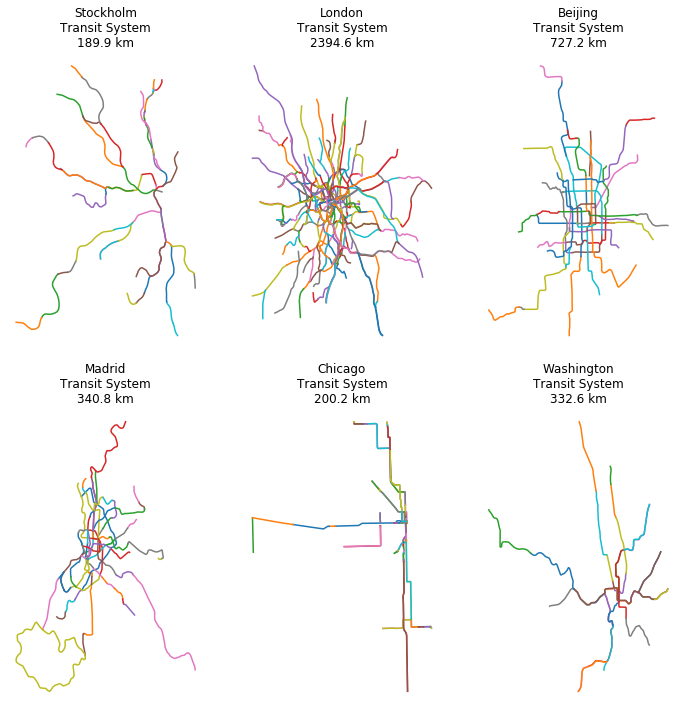

In [39]:
codes = 110, 69, 15, 71, 147, 252

fig, axx = plt.subplots(2, 3, figsize=(12, 12))

for code, ax in zip(codes, axx.flatten()):
    name = cities['name'][code]
    length = 0
    for line in tracks[tracks['city_id'] == code]['geometry']:
        xy = parse_linestring(line)
        ax.plot(xy[:,0], xy[:, 1])
        length += route_length(xy)
    ax.set_title(f'{name}\nTransit System\n{length:.1f} km')
    ax.axis(False);
    
# save into a PNG file
fig.savefig('map.png', dpi=300)

Now compile cities into a structure with the key of city name and the value of its transit system length.

In [42]:
systems = {}

for code in cities.index:
    length = 0
    name = cities['name'][code]
    for line in tracks[tracks['city_id'] == code]['geometry']:
        try:
            xy = parse_linestring(line)
        except ValueError:
            continue
        length += route_length(xy)
    if length:
        print(f"{code} {name} {length:.1f} km")
        systems[name] = length

147 Chicago 200.2 km
280 Clermont-Ferrand 34.3 km
268 San Sebastián 81.4 km
29 Budapest 77.5 km
23 Bordeaux 135.9 km
19 Berlin 1.3 km
283 Besancon 35.1 km
45 Edinburgh 6.7 km
48 Glasgow 618.6 km
294 Le Mans 40.1 km
56 Hong Kong 35.4 km
63 Kuala Lumpur 86.4 km
300 Montpellier 108.1 km
70 Lyons 148.6 km
67 Lisbon 118.0 km
72 Manchester 8.4 km
82 Munich 183.2 km
74 Marseilles 79.1 km
79 Milan 624.5 km
310 Rouen 31.8 km
305 Dijon 41.1 km
317 Mulhouse 58.8 km
324 Nice 16.5 km
314 Reims 12.6 km
318 Nancy 20.1 km
308 Orleans 46.1 km
331 Le Havre 32.4 km
327 Lille 99.2 km
91 Osaka 2633.9 km
87 Naples 24.1 km
95 Paris 706.5 km
325 Toulouse 46.3 km
89 Newcastle-on-Tyne 195.6 km
328 Strasbourg 53.8 km
104 Salvador 27.2 km
99 Prague 115.6 km
307 Tours 30.0 km
103 Rome 156.1 km
275 Angers 37.2 km
106 São Paulo 842.1 km
286 Grenoble 91.0 km
111 Sydney 370.9 km
77 Melbourne 65.9 km
102 Rio de Janeiro 167.8 km
64 La Paz 34.2 km
114 Tokyo 5204.0 km
293 Brest 33.2 km
116 Venice 55.2 km
124 Valparaíso 78

In [43]:
# sort by values 
systems = {k: systems[k] for k in sorted(systems, key=systems.get)}

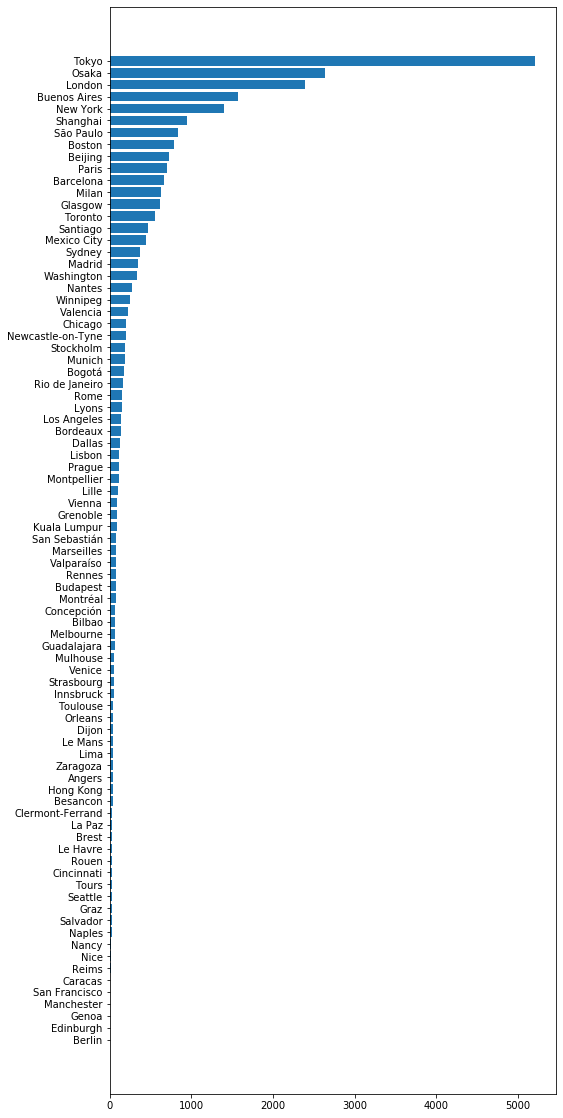

In [44]:
# plot the horizontal barplot of all the cities and  
fig, ax = plt.subplots(1, 1, figsize=(8, 20))
ax.barh(np.r_[:len(systems)], list(systems.values()))
ax.set_yticks(np.r_[:len(systems)])
ax.set_yticklabels(list(systems));

# Final Project

Work with the citylines datasets to produce several visualizations and present them in class. The first four visualization are specified. Come up with four additional ones for the presentation. Describe your work.

## Visualizaiton

1. Maps of 12 selected cities on a grid, e.g. 3$\times$4 with each line in a different color (mostly solved above)
2. A bar plot of the total lengths of each city's tranit lines (mostly solved above)
3. Total length of the transit lines across all cities across time (km), or change per decade. 
4. World map of cities with an indication of the size of the transit city as a dot size or color.
5. come up with an interesting question and visualization
6. come up with an interesting question and visualization
7. come up with an interesting question and visualization
8. come up with an interesting question and visualization
  